# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля.

Необходимо построить модель, которая будет определять рыночную стоимость автомобиля по различным характеристикам.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Содержание**<a id='toc0_'></a> 


1. [Подготовка данных](#toc1_)                                  
  1.1 [Установка библиотек и конфигурации](#toc1_1_)    
  1.2 [Функции, используемые в проекте](#toc1_2_) 
  
2. [Предобработка данных](#toc2_)         
  2.1 [Загрузка данных](#toc2_1_)    
  2.2 [Типы данных](#toc2_2_)    
  2.3 [Обработка дубликатов](#toc2_3_)                                    
  2.4 [Исследование пропусков](#toc2_4_)

3. [Исследовательский анализ данных(EDA)](#toc3_)  

4. [Корреляционный анализ](#toc4_)                           
 
5. [Построение моделей и пайплайнов](#toc5_)                          
 5.1 [Подготовка данных](#toc5_1_)                                                                                             
 5.2 [Linear Regression](#toc5_2_)                           
 5.3 [CatBoostRegressor](#toc5_3_)                          
 5.4 [LGBMRegressor](#toc5_4_)                                    
 5.5 [Метрика на тестовом датасете](#toc5_5_)                                
 5.6 [Важность признаков](#toc5_6_)                      

6. [Общий вывод](#toc6_)
 
  

## <a id='toc1_'></a> Подготовка данных[&#8593;](#toc0_)

### <a id='toc1_1_'></a>Установка библиотек  и конфигурации [&#8593;](#toc0_)

In [1]:
from IPython.display import clear_output

In [2]:
%pip install --upgrade -q numpy
%pip install matplotlib==3.5.2
%pip install --upgrade -q phik
%pip install --upgrade -q shap
%pip install --upgrade -q prettytable
%pip install --upgrade -q termcolor
%pip install --upgrade -q seaborn
%pip install --upgrade -q pandas
%pip install --upgrade -q statsmodels
%pip install --upgrade -q scikit-learn
%pip install --upgrade -q missingno
%pip install --upgrade -q catboost
%pip install --upgrade -q lightgbm

clear_output()

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import re
import missingno as msno

from os.path import exists

# preprocessing
from sklearn.model_selection import (
    GridSearchCV,                                 
    train_test_split)
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder)
from sklearn.impute import (
    SimpleImputer)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
# metrics
from sklearn.metrics import root_mean_squared_error

# additional tools
from phik import phik_matrix 
from prettytable import PrettyTable
from termcolor import colored
from sklearn.inspection import permutation_importance

In [4]:
RANDOM_STATE = 42
TEST_SIZE = 0.2

pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)

### <a id='toc1_2_'></a>Функции, используемые в проекте [&#8593;](#toc0_)

In [5]:
def get_dataframe(paths: list[str]) -> pd.DataFrame:
    for _path in paths:
        if not exists(_path) and not _path.startswith('http'):
            continue
        
        try:
            df = pd.read_csv(_path)
        except:
            continue
        
        if df is None:
            continue
        
        return df
    
    raise FileNotFoundError('No paths are valid and/or for correct csv file.')

In [6]:
def print_nans_table(data: pd.DataFrame) -> None:
    table = PrettyTable()
    table.field_names = ['Признаки', 'Пропущенное количество значений']
    
    missing_info = data.isna().sum().sort_values()
    cols = missing_info.index.to_list()
    for col in cols:
        count = missing_info[col]
        color = 'blue' if count == 0 else 'red'
        s = f'{count} ({count / len(data):.1%})'
        table.add_row([col, colored(s, color)])
    
    print(table)

In [7]:
def the_basic_plots(df: pd.DataFrame,
                    column: str,
                    column_description: str,
                    bins: int = 25
                    ) -> None:
    
    _, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10, 6))

    sns.boxplot(data=df, x=column, ax=ax1)
    ax1.set_xlabel(column_description)
    ax1.grid()

    sns.histplot(data=df, x=column, bins=bins, ax=ax2)
    ax2.set_xlabel(column_description)
    ax2.grid()
    ax2.set_ylabel('Количество')

    plt.suptitle(f'Информация о колонке {column_description}', fontsize=18)
    plt.tight_layout()

    plt.show()

In [8]:
def plot_pie_chart(series: pd.Series, title: str) -> None:
    table_1 = series.value_counts()
    data, labels = table_1.values, table_1.index
    plt.pie(data, labels=labels, autopct='%.0f%%')
    plt.title(title)
    plt.show()

In [9]:
def count_plot_(column: str, data: pd.DataFrame) -> None:
    ax = sns.countplot(x = column,  data = data)
    plt.grid()
    ax.bar_label(ax.containers[0])
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.title(f'Информация о колонке {column}', fontsize=12)
    plt.show()

In [10]:
def get_plots_about_residuals(y_true: np.array, y_pred: np.array) -> None:
    res = y_true - y_pred
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    
    sns.histplot(res, ax=ax1)
    ax1.set_xlabel('Остатки')
    ax1.set_ylabel('Количество')
    ax1.axvline(x=0, color='green', lw=3, ls='-', label='Нулевое значение')
    ax1.axvline(x=res.mean(), color='red', lw=3, ls='--', label='Среднее значение остатков')
    ax1.legend()
    
    sns.scatterplot(x=y_pred, y=res, ax=ax2)
    ax2.set_xlabel('Предсказанные значение')
    ax2.set_ylabel('Остатки')
    
    fig.suptitle('Информация об остатках')

In [11]:
def pep8_snakecase_str(s: str) -> str:
    
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', s)

    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

In [12]:
def date_to_parts(column: str, data: pd.DataFrame) -> None:
    data[f'year_{column}'] = data[column].dt.year
    data[f'month_{column}'] = data[column].dt.month
    data[f'day_{column}'] = data[column].dt.day
    if (data[column].dt.hour == 0).all().sum()!=1:
        data[f'hour_{column}'] = data[column].dt.hour
    if (data[column].dt.minute == 0).all().sum()!=1:    
        data[f'minute_{column}'] = data[column].dt.minute
    if (data[column].dt.second == 0).all().sum()!=1:        
        data[f'second_{column}'] = data[column].dt.second

    return data.head(3)

## <a id='toc2_'></a> Предобработка данных [&#8593;](#toc0_)

### <a id='toc2_1_'></a>Загрузка данных [&#8593;](#toc0_)

In [13]:
df = get_dataframe(['/datasets/autos.csv'])

In [14]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Названия столбцов не соответствуют стандарту pep8, преобразуем их:

In [15]:
df.columns = [pep8_snakecase_str(col) for col in df.columns]

In [16]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

### <a id='toc2_2_'></a>Типы данных [&#8593;](#toc0_)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [18]:
df['date_crawled'] = pd.to_datetime(df['date_crawled'])

In [19]:
df['date_created'] = pd.to_datetime(df['date_created'])
df['last_seen'] = pd.to_datetime(df['last_seen'])

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

### <a id='toc2_3_'></a>Обработка дубликатов [&#8593;](#toc0_)

In [21]:
df.duplicated().sum()

4

In [22]:
df.loc[df.duplicated()==True]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15


Удалим данные дубликаты:

In [23]:
df = df.drop_duplicates()

In [24]:
df.duplicated().sum()

0

### <a id='toc2_4_'></a>Исследование пропусков[&#8593;](#toc0_)

In [25]:
print_nans_table(df)

+--------------------+---------------------------------+
|      Признаки      | Пропущенное количество значений |
+--------------------+---------------------------------+
|    date_crawled    |             0 (0.0%)            |
|       price        |             0 (0.0%)            |
| registration_year  |             0 (0.0%)            |
|       power        |             0 (0.0%)            |
|     kilometer      |             0 (0.0%)            |
| registration_month |             0 (0.0%)            |
|       brand        |             0 (0.0%)            |
|    date_created    |             0 (0.0%)            |
| number_of_pictures |             0 (0.0%)            |
|    postal_code     |             0 (0.0%)            |
|     last_seen      |             0 (0.0%)            |
|       model        |           19705 (5.6%)          |
|      gearbox       |           19833 (5.6%)          |
|     fuel_type      |           32895 (9.3%)          |
|    vehicle_type    |         

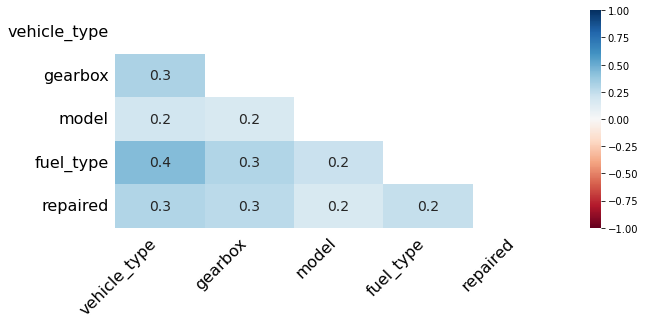

In [26]:
msno.heatmap(df, figsize=(10, 4));

В целом, пропуски закономерны и не коррелируют между собой. В подобных данных могут быть пропущены данные о типе топлива или кузова из-за человеческого фактора. Заполним эти пропуски позже.

## <a id='toc3_'></a> Исследовательский анализ данных (EDA) [&#8593;](#toc0_)

**Признаки:**

- date_crawled — дата скачивания анкеты из базы
- vehicle_type — тип автомобильного кузова
- registration_year — год регистрации автомобиля
- gearbox — тип коробки передач
- power — мощность (л. с.)
- model — модель автомобиля
- kilometer — пробег (км)
- registration_month — месяц регистрации автомобиля
- fuel_type — тип топлива
- brand — марка автомобиля
- repaired — была машина в ремонте или нет
- date_created — дата создания анкеты
- number_of_pictures — количество фотографий автомобиля
- postal_code — почтовый индекс владельца анкеты (пользователя)
- last_seen — дата последней активности пользователя

**Целевой признак:**
- price — цена (евро)

1. Столбец date_crawled

In [27]:
df['date_crawled'].describe()

count                           354365
mean     2016-03-21 12:58:09.520460544
min                2016-03-05 14:06:22
25%                2016-03-13 11:52:33
50%                2016-03-21 17:50:55
75%                2016-03-29 14:37:20
max                2016-04-07 14:36:58
Name: date_crawled, dtype: object

2. Столбец vehicle_type

In [28]:
df['vehicle_type'].value_counts()

vehicle_type
sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: count, dtype: int64

In [29]:
df['vehicle_type'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

Заменим пропуски на other:

In [30]:
df['vehicle_type'] = df['vehicle_type'].fillna('other')

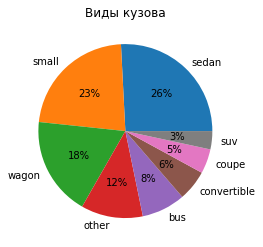

In [31]:
plot_pie_chart(df['vehicle_type'], 'Виды кузова')

3. Столбец registration_year

In [32]:
df['registration_year'].value_counts()

registration_year
2000    24490
1999    22727
2005    22109
2001    20123
2006    19900
        ...  
6500        1
2290        1
1001        1
9450        1
3500        1
Name: count, Length: 151, dtype: int64

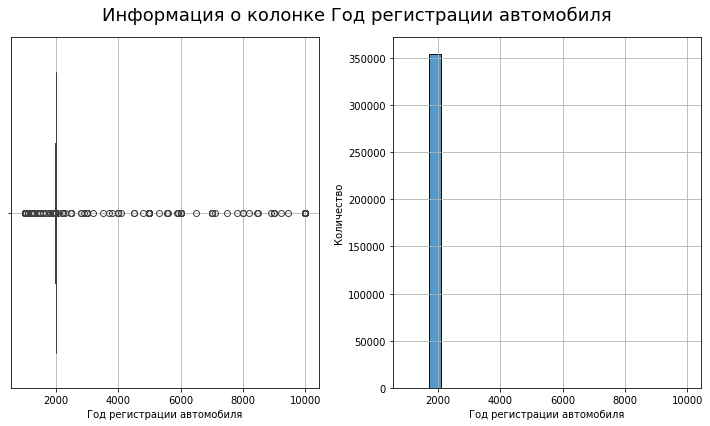

In [33]:
the_basic_plots(df, 'registration_year', 'Год регистрации автомобиля')

Видим сильно выбивающиеся значения, удалим их:

In [34]:
df.loc[(df['registration_year']>=2017) | (df['registration_year']<=1884), 'registration_year'].count()

14596

Количество аномальных строчек составляет примерно 4% от общего количества.

In [35]:
df = df.loc[(df['registration_year']<2017) & (df['registration_year']>1884)]

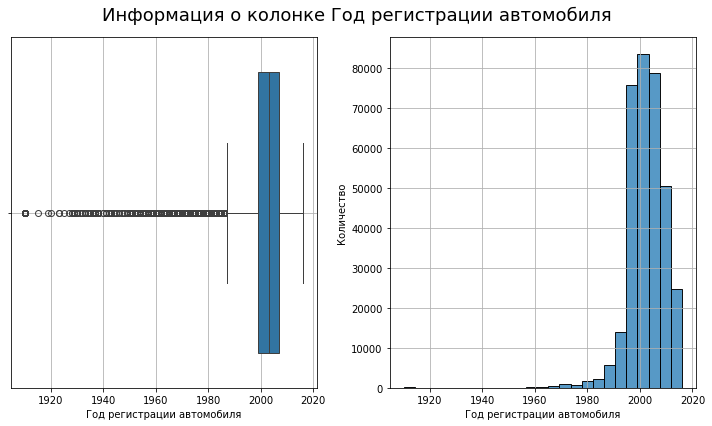

In [36]:
the_basic_plots(df, 'registration_year', 'Год регистрации автомобиля')

Учитывая, что мы рассматриваем статистику относительно современных автомобилей, посмотрим, сколько машин с годом выпуска < 1960:

In [37]:
df.loc[df['registration_year']<1960, 'registration_year'].count()

356

Удалим их тоже, чтобы не сдвигать в будущем показания модели.

In [38]:
df = df.loc[df['registration_year']>1960]

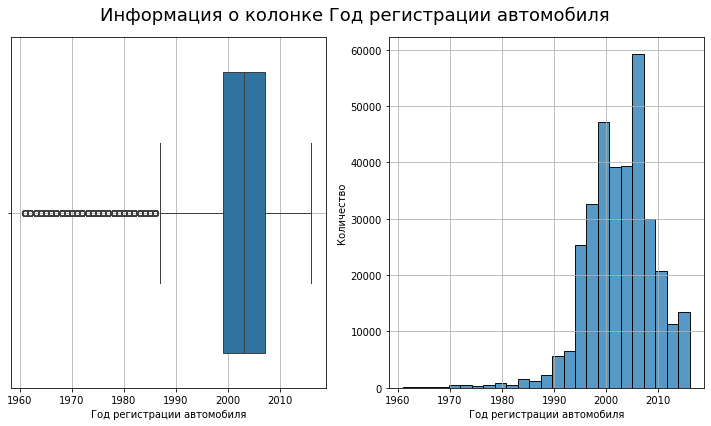

In [39]:
the_basic_plots(df, 'registration_year', 'Год регистрации автомобиля')

Теперь распределение похоже на нормальное.

4. Столбец gearbox

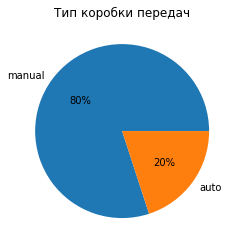

In [40]:
plot_pie_chart(df['gearbox'], 'Тип коробки передач')

В данном столбце есть пропуски, рассмотрим их:

In [41]:
df['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

Заменим пропуски значением 'unknown':

In [42]:
df['gearbox'] = df['gearbox'].fillna('unknown')

In [43]:
df['gearbox'].unique()

array(['manual', 'auto', 'unknown'], dtype=object)

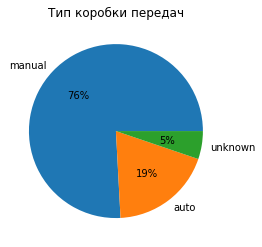

In [44]:
plot_pie_chart(df['gearbox'], 'Тип коробки передач')

5. Столбец power

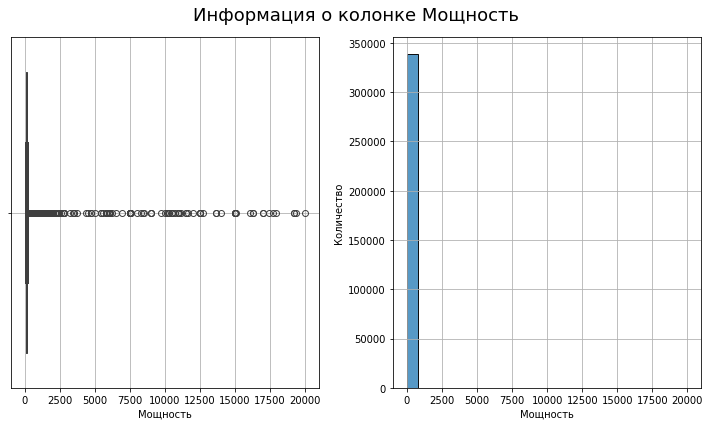

In [45]:
the_basic_plots(df, 'power', 'Мощность')

In [46]:
df.loc[(df['power']<50) | (df['power']>1000), 'power'].count()

42016

Возможно, что околонулевые значения по мощности возникли из-за того, что некоторые машины продают в разборку по запчастям. Высокие значения по мощности - скорее всего ошибки людей. Поэтому удалим данные значения, так как они для нас являются аномальными.

In [47]:
df = df.loc[(df['power']>50) & (df['power']<=1000)]

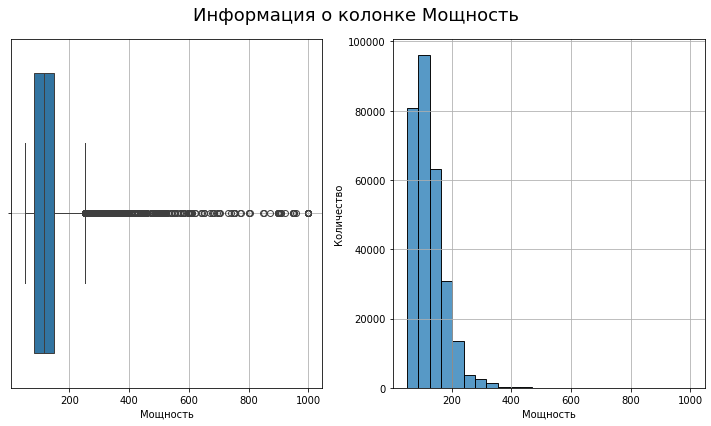

In [48]:
the_basic_plots(df, 'power', 'Мощность')

6. Столбец model

In [49]:
df['model'].unique()

array([nan, 'grand', 'golf', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'other', 'civic', 'punto', 'e_klasse', 'clio',
       'kadett', 'one', 'fortwo', '1er', 'b_klasse', 'a8', 'jetta',
       'c_klasse', 'micra', 'vito', 'sprinter', 'astra', '156', 'escort',
       'forester', 'xc_reihe', 'fiesta', 'scenic', 'ka', 'a1',
       'transporter', 'focus', 'a4', 'tt', 'a6', 'jazz', 'omega', 'slk',
       '7er', 'combo', 'corsa', '80', '147', 'meriva', 'z_reihe',
       'sorento', 'ibiza', 'mustang', 'eos', 'touran', 'getz', 'insignia',
       'almera', 'megane', 'a3', 'r19', 'caddy', 'mondeo', 'cordoba',
       'colt', 'impreza', 'vectra', 'lupo', 'berlingo', 'tiguan',
       '6_reihe', 'c4', 'panda', 'up', 'i_reihe', 'ceed', 'kangoo',
       '5_reihe', 'yeti', 'octavia', 'zafira', 'mii', 'rx_reihe', '6er',
       'modus', 'fox', 'matiz', 'beetle', 'rio', 'touareg', 'logan',
       'spider', 'cuore', 's_

Есть пропущенные значения, поставим вместо них значение other:

In [50]:
df['model'] = df['model'].fillna('other')

In [51]:
df['model'].unique()

array(['other', 'grand', 'golf', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'civic', 'punto', 'e_klasse', 'clio', 'kadett',
       'one', 'fortwo', '1er', 'b_klasse', 'a8', 'jetta', 'c_klasse',
       'micra', 'vito', 'sprinter', 'astra', '156', 'escort', 'forester',
       'xc_reihe', 'fiesta', 'scenic', 'ka', 'a1', 'transporter', 'focus',
       'a4', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', 'combo', 'corsa',
       '80', '147', 'meriva', 'z_reihe', 'sorento', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'insignia', 'almera', 'megane', 'a3',
       'r19', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza', 'vectra',
       'lupo', 'berlingo', 'tiguan', '6_reihe', 'c4', 'panda', 'up',
       'i_reihe', 'ceed', 'kangoo', '5_reihe', 'yeti', 'octavia',
       'zafira', 'mii', 'rx_reihe', '6er', 'modus', 'fox', 'matiz',
       'beetle', 'rio', 'touareg', 'logan', 'spider', 'cuore', 's_max',
      

Видим, что очень большое количество категорий в названиях моделей. Посмотрим на распределение

In [52]:
df['model'].value_counts()

model
other                 31309
golf                  25318
3er                   17791
astra                  9299
corsa                  9035
                      ...  
i3                        5
serie_2                   4
serie_3                   3
range_rover_evoque        2
rangerover                2
Name: count, Length: 248, dtype: int64

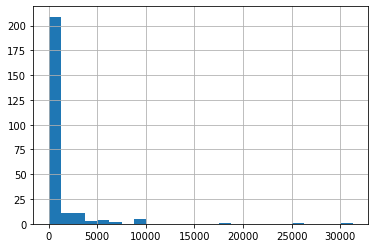

In [53]:
df['model'].value_counts().hist(bins=25);

Большинство моделей относятся к "другим", а так же к VW Golf и BMW 3er.

7. Столбец kilometer

In [54]:
df['kilometer'].describe()

count   292772.00
mean    128541.54
std      36653.12
min       5000.00
25%     125000.00
50%     150000.00
75%     150000.00
max     150000.00
Name: kilometer, dtype: float64

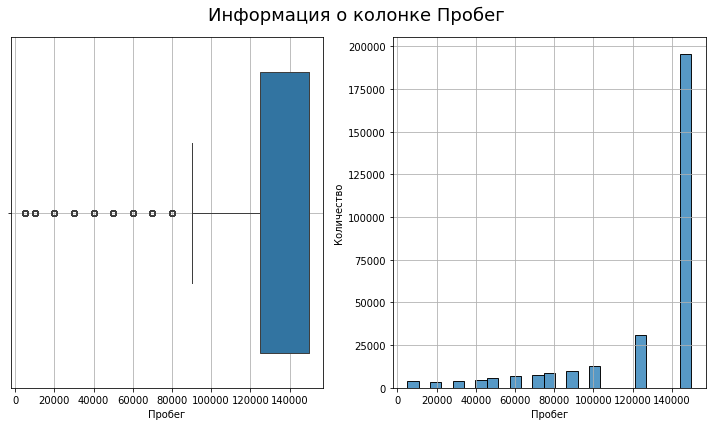

In [55]:
the_basic_plots(df, 'kilometer', 'Пробег')

8. Столбец registration_month

In [56]:
df['registration_month'].value_counts()

registration_month
3     29879
6     27249
4     25370
5     25317
7     23488
10    22637
12    20939
11    20745
9     20701
1     19824
8     19541
2     18560
0     18522
Name: count, dtype: int64

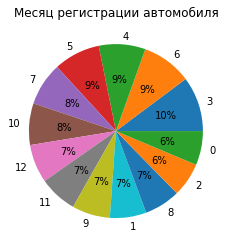

In [57]:
plot_pie_chart(df['registration_month'], 'Месяц регистрации автомобиля')

9. Столбец fuel_type

In [58]:
df['fuel_type'].unique()

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [59]:
df['fuel_type'].value_counts()

fuel_type
petrol      183437
gasoline     88126
lpg           4774
cng            484
hybrid         201
other           56
electric        34
Name: count, dtype: int64

Заменим пропущенные значения на other, к тому же уже есть такое значение:

In [60]:
df['fuel_type'] = df['fuel_type'].fillna('other')

In [61]:
df['fuel_type'].value_counts()

fuel_type
petrol      183437
gasoline     88126
other        15716
lpg           4774
cng            484
hybrid         201
electric        34
Name: count, dtype: int64

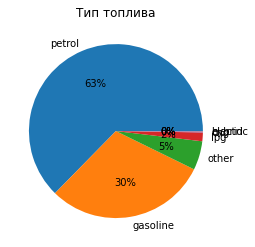

In [62]:
plot_pie_chart(df['fuel_type'], 'Тип топлива')

10. Столбец Brand

In [63]:
df['brand'].unique()

array(['audi', 'jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'honda', 'fiat',
       'opel', 'mini', 'smart', 'hyundai', 'sonstige_autos', 'alfa_romeo',
       'subaru', 'volvo', 'mitsubishi', 'kia', 'seat', 'lancia',
       'citroen', 'toyota', 'chevrolet', 'dacia', 'suzuki', 'daihatsu',
       'saab', 'chrysler', 'jaguar', 'daewoo', 'rover', 'porsche',
       'land_rover', 'lada', 'trabant'], dtype=object)

In [64]:
df['brand'].value_counts()

brand
volkswagen        61723
bmw               32963
opel              31953
mercedes_benz     27758
audi              26236
ford              20344
renault           13981
peugeot            9278
fiat               7422
seat               5333
skoda              4968
mazda              4778
citroen            4201
nissan             4052
toyota             4035
smart              3529
hyundai            3125
mini               2968
volvo              2872
mitsubishi         2566
honda              2436
kia                2126
alfa_romeo         2023
suzuki             1929
sonstige_autos     1549
chevrolet          1468
chrysler           1201
dacia               805
subaru              657
porsche             637
jeep                574
daihatsu            554
saab                482
land_rover          468
jaguar              446
daewoo              406
rover               382
lancia              378
lada                160
trabant               6
Name: count, dtype: int64

<AxesSubplot:>

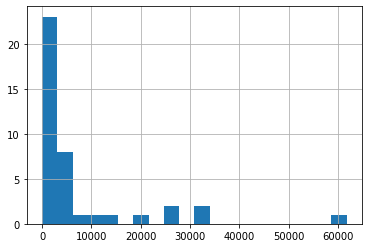

In [65]:
df['brand'].value_counts().hist(bins=20)

Наиболее распространенные марки машин в выборке соответственно VW и BMW, что было видно и по моделям.

11. Столбец Repaired

In [66]:
df['repaired'].unique()

array(['yes', nan, 'no'], dtype=object)

Заполним пропуски значением 'unknown'

In [67]:
df['repaired'] = df['repaired'].fillna('unknown')

In [68]:
df['repaired'].value_counts()

repaired
no         221028
unknown     42812
yes         28932
Name: count, dtype: int64

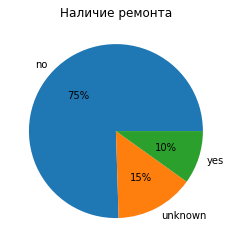

In [69]:
plot_pie_chart(df['repaired'], 'Наличие ремонта')

12. Столбец DateCreated

In [70]:
df['date_created'].describe()

count                           292772
mean     2016-03-20 19:19:49.343242752
min                2015-03-20 00:00:00
25%                2016-03-13 00:00:00
50%                2016-03-21 00:00:00
75%                2016-03-29 00:00:00
max                2016-04-07 00:00:00
Name: date_created, dtype: object

13. Столбец number_of_pictures 

In [71]:
df['number_of_pictures'].value_counts()

number_of_pictures
0    292772
Name: count, dtype: int64

Данный столбец не имеет значения, удалим его:

In [72]:
df = df.drop(columns=['number_of_pictures'])

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 292772 entries, 1 to 354368
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        292772 non-null  datetime64[ns]
 1   price               292772 non-null  int64         
 2   vehicle_type        292772 non-null  object        
 3   registration_year   292772 non-null  int64         
 4   gearbox             292772 non-null  object        
 5   power               292772 non-null  int64         
 6   model               292772 non-null  object        
 7   kilometer           292772 non-null  int64         
 8   registration_month  292772 non-null  int64         
 9   fuel_type           292772 non-null  object        
 10  brand               292772 non-null  object        
 11  repaired            292772 non-null  object        
 12  date_created        292772 non-null  datetime64[ns]
 13  postal_code         292772 non-nul

14. Столбец postal_code

In [74]:
df['postal_code'].describe()

count   292772.00
mean     51263.08
std      25815.44
min       1067.00
25%      30938.00
50%      50321.00
75%      72124.00
max      99998.00
Name: postal_code, dtype: float64

In [75]:
df['postal_code'].value_counts()

postal_code
10115    800
65428    501
66333    270
60311    263
52525    247
        ... 
16837      1
89183      1
29393      1
99898      1
95691      1
Name: count, Length: 8114, dtype: int64

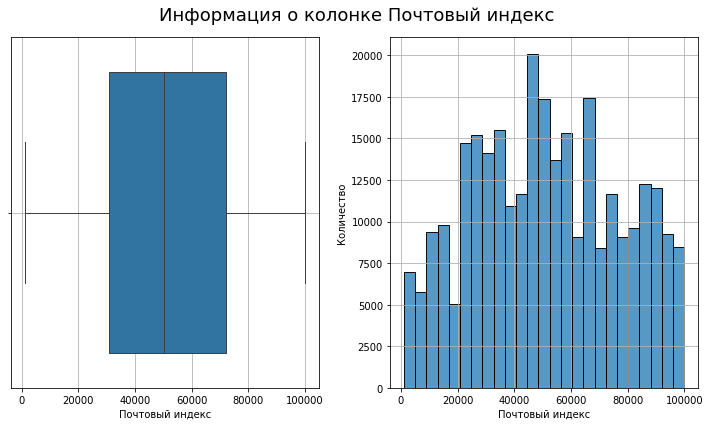

In [76]:
the_basic_plots(df, 'postal_code', 'Почтовый индекс')

15. Столбец last_seen 

In [77]:
df['last_seen'].describe()

count                           292772
mean     2016-03-30 04:48:48.858244096
min                2016-03-05 14:15:08
25%                2016-03-23 13:38:36
50%                2016-04-04 01:46:27
75%                2016-04-06 10:46:03
max                2016-04-07 14:58:51
Name: last_seen, dtype: object

16. Target-столбец Price

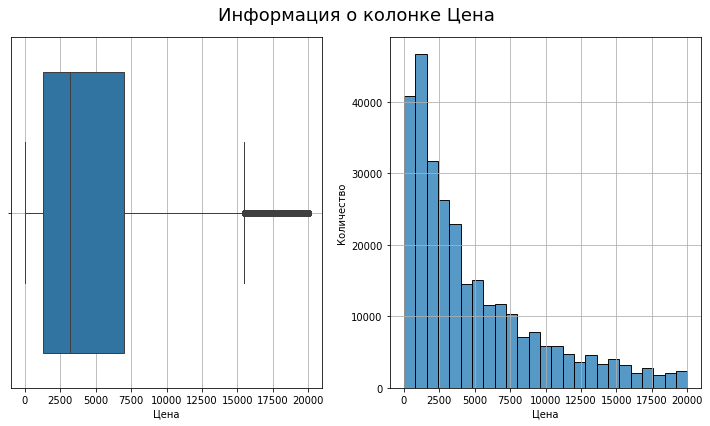

In [78]:
the_basic_plots(df, 'price', 'Цена')

In [79]:
df.loc[df['price']==0, 'price'].count()

6033

In [80]:
df['price'].describe()

count   292772.00
mean      4858.71
std       4634.52
min          0.00
25%       1300.00
50%       3200.00
75%       6999.00
max      20000.00
Name: price, dtype: float64

Нулевые значения обуславливаются потенциальным желанием отдать бесплатно машину

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 292772 entries, 1 to 354368
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        292772 non-null  datetime64[ns]
 1   price               292772 non-null  int64         
 2   vehicle_type        292772 non-null  object        
 3   registration_year   292772 non-null  int64         
 4   gearbox             292772 non-null  object        
 5   power               292772 non-null  int64         
 6   model               292772 non-null  object        
 7   kilometer           292772 non-null  int64         
 8   registration_month  292772 non-null  int64         
 9   fuel_type           292772 non-null  object        
 10  brand               292772 non-null  object        
 11  repaired            292772 non-null  object        
 12  date_created        292772 non-null  datetime64[ns]
 13  postal_code         292772 non-nul

Поменяем типы данных на менее затратные по памяти. Столько места, как в int64, для наших данных не понадобится.


In [82]:
for column in df.columns:
    if df[column].dtype == 'int64':
        df[column] = df[column].astype('int32')

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 292772 entries, 1 to 354368
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        292772 non-null  datetime64[ns]
 1   price               292772 non-null  int32         
 2   vehicle_type        292772 non-null  object        
 3   registration_year   292772 non-null  int32         
 4   gearbox             292772 non-null  object        
 5   power               292772 non-null  int32         
 6   model               292772 non-null  object        
 7   kilometer           292772 non-null  int32         
 8   registration_month  292772 non-null  int32         
 9   fuel_type           292772 non-null  object        
 10  brand               292772 non-null  object        
 11  repaired            292772 non-null  object        
 12  date_created        292772 non-null  datetime64[ns]
 13  postal_code         292772 non-nul

**ВЫВОД:**
В ходе предобработки данных, мы удалили полные дубликаты. Пропуски в 5 столбцах мы заменили на "unknown" или "other", так как признаки являются категориальными.

В ходе EDA был удален неинформативный признак, связанные с количеством предоставленных фото. Были удалены строчки с аномальными значениями по некоторым из признаков:

- Неактуальные или несуществующие годы регистрации авто
- Нерелевантные значения мощности двигателя

Были изменены некоторые типы данных для экономии памяти.

## <a id='toc4_'></a> Корреляционный анализ [&#8593;](#toc0_)

**Признаки:**

- date_crawled — дата скачивания анкеты из базы
- vehicle_type — тип автомобильного кузова
- registration_year — год регистрации автомобиля
- gearbox — тип коробки передач
- power — мощность (л. с.)
- model — модель автомобиля
- kilometer — пробег (км)
- registration_month — месяц регистрации автомобиля
- fuel_type — тип топлива
- brand — марка автомобиля
- repaired — была машина в ремонте или нет
- date_created — дата создания анкеты
- number_of_pictures — количество фотографий автомобиля
- postal_code — почтовый индекс владельца анкеты (пользователя)
- last_seen — дата последней активности пользователя

**Целевой признак:**
- price — цена (евро)

In [84]:
target = 'price'

cat_cols = [
    'vehicle_type',
    'gearbox',
    'model',
    'fuel_type',
    'brand',
    'repaired'
]

date_cols = [
    'date_crawled',
    'date_created',
    'last_seen'
]

num_cols = [
    'registration_year',
    'power',
    'kilometer',
    'registration_month'
]


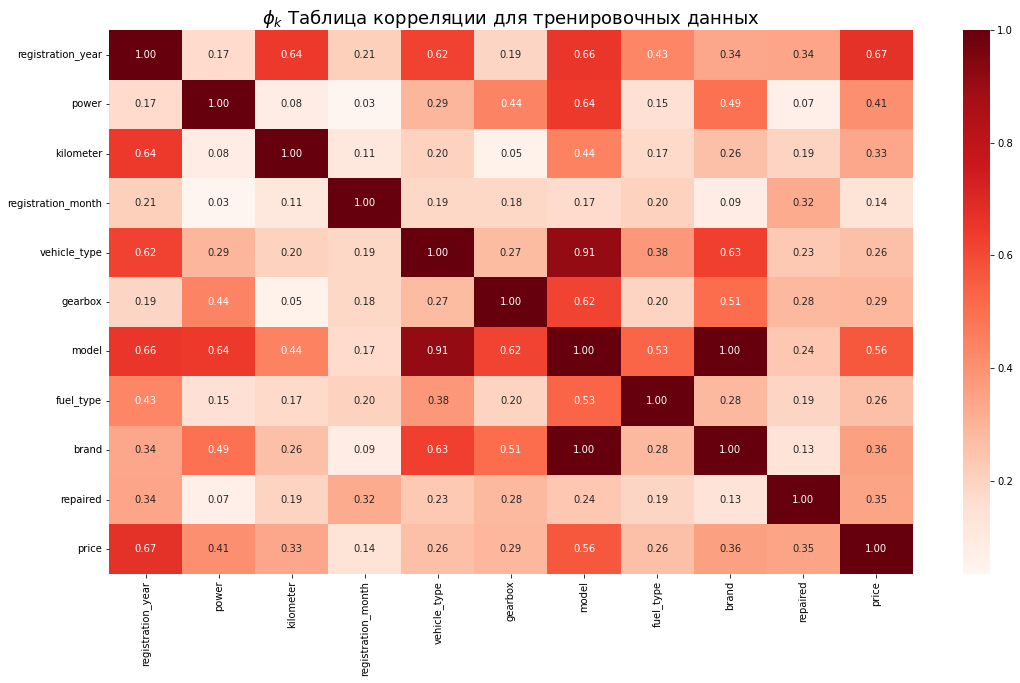

In [85]:
plt.figure(figsize=(18, 10))
colss = num_cols + cat_cols + [target]
sns.heatmap(df[colss].phik_matrix(interval_cols=['power']+[target]),
            cmap='Reds',
            annot=True,
            fmt='.2f')
plt.title(r'$\phi_k$ Таблица корреляции для тренировочных данных', fontsize=18);

В целом, никакой чрезмерно высокой или низкой корреляции мы не наблюдаем. Из рассмотрения в модели стоит удалить признак model, так как brand полностью идентичен с точки зрения идентификации, и таким образом мы сэкономим время обучения.

Так же из рассмотрения в модели стоит исключить date_crawled и registration_month.

## <a id='toc5_'></a> Построение моделей и пайплайнов [&#8593;](#toc0_)

### <a id='toc5_1_'></a> Подготовка данных [&#8593;](#toc0_)

In [86]:
target = 'price'

ohe_cols = [
    'brand',
    'fuel_type',
    'vehicle_type'
]

ord_cols = [
    'gearbox', 
    'repaired'
]


date_cols = [
    'date_created',
    'last_seen'
]


num_cols = [
    'registration_year',
    'power',
    'kilometer'
]


drop_cols = [
    'date_crawled',
    'registration_month',
    'model'    
]

In [87]:
X = df.drop(columns= drop_cols + [target])
y = df[target]

X.shape, y.shape

((292772, 11), (292772,))

In [88]:
date_to_parts('date_created',X)

,vehicle_type,registration_year,gearbox,power,kilometer,fuel_type,brand,repaired,date_created,postal_code,last_seen,year_date_created,month_date_created,day_date_created
1,coupe,2011,manual,190,125000,gasoline,audi,yes,2016-03-24,66954,2016-04-07 01:46:50,2016,3,24
2,suv,2004,auto,163,125000,gasoline,jeep,unknown,2016-03-14,90480,2016-04-05 12:47:46,2016,3,14
3,small,2001,manual,75,150000,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17,2016,3,17


In [89]:
date_to_parts('last_seen',X)

,vehicle_type,registration_year,gearbox,power,kilometer,fuel_type,brand,repaired,date_created,postal_code,last_seen,year_date_created,month_date_created,day_date_created,year_last_seen,month_last_seen,day_last_seen,hour_last_seen,minute_last_seen,second_last_seen
1,coupe,2011,manual,190,125000,gasoline,audi,yes,2016-03-24,66954,2016-04-07 01:46:50,2016,3,24,2016,4,7,1,46,50
2,suv,2004,auto,163,125000,gasoline,jeep,unknown,2016-03-14,90480,2016-04-05 12:47:46,2016,3,14,2016,4,5,12,47,46
3,small,2001,manual,75,150000,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17,2016,3,17,2016,3,17,17,40,17


In [90]:
X = X.drop(columns= date_cols)

In [91]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 292772 entries, 1 to 354368
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   vehicle_type        292772 non-null  object
 1   registration_year   292772 non-null  int32 
 2   gearbox             292772 non-null  object
 3   power               292772 non-null  int32 
 4   kilometer           292772 non-null  int32 
 5   fuel_type           292772 non-null  object
 6   brand               292772 non-null  object
 7   repaired            292772 non-null  object
 8   postal_code         292772 non-null  int32 
 9   year_date_created   292772 non-null  int32 
 10  month_date_created  292772 non-null  int32 
 11  day_date_created    292772 non-null  int32 
 12  year_last_seen      292772 non-null  int32 
 13  month_last_seen     292772 non-null  int32 
 14  day_last_seen       292772 non-null  int32 
 15  hour_last_seen      292772 non-null  int32 
 16  minute_

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
display((X_train.shape, y_train.shape))
display((X_test.shape, y_test.shape))

((234217, 18), (234217,))

((58555, 18), (58555,))

Категории признаков:

In [93]:
target = 'price'

ohe_cols = [
    'brand',
    'fuel_type',
    'vehicle_type',
    'gearbox', 
    'repaired'
]

num_cols = [
    'registration_year',
    'power',
    'kilometer',
    'year_date_created',
    'month_date_created',
    'day_date_created',
    'year_last_seen',
    'year_last_seen',
    'month_last_seen',
    'day_last_seen',
    'hour_last_seen',
    'minute_last_seen',
    'second_last_seen'
]



### <a id='toc5_2_'></a> LinearRegression[&#8593;](#toc0_)

In [94]:
data_preprocessor_lr = ColumnTransformer(
    [('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False, min_frequency=0.01), ohe_cols),
     ('num', StandardScaler(), num_cols)
    ], 
    force_int_remainder_cols=False,
    remainder='passthrough'
)

In [95]:
final_pipe_lr = Pipeline(
    [
        ('preprocessor', data_preprocessor_lr),
        ('models', LinearRegression())
    ]
)

In [96]:
param_grid_lr = [

    {
        'models': [LinearRegression(n_jobs=-1)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
]

In [97]:
grid_lr = GridSearchCV(
    final_pipe_lr,
    param_grid=param_grid_lr,
    scoring= 'neg_root_mean_squared_error'
)

In [98]:
%%time
grid_lr.fit(X_train, y_train)

CPU times: user 34.1 s, sys: 10.2 s, total: 44.4 s
Wall time: 44.4 s


GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       min_frequency=0.01,
                                                                                       sparse_output=False),
                                                                         ['brand',
                                                                          'fuel_type',
                                                                          'vehicle_type',
                                                                          'gearbox',
                                                                          'repaired']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['registration_year',
                                                                          'power...
                                                                          'month_date_created',
                                                                          'day_date_created',
                                                                          'year_last_seen',
                                                                          'year_last_seen',
                                                                          'month_last_seen',
                                                                          'day_last_seen',
                                                                          'hour_last_seen',
                                                                          'minute_last_seen',
                                                                          'second_last_seen'])])),
                                       ('models', LinearRegression())]),
             param_grid=[{'models': [LinearRegression(n_jobs=-1)],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='neg_root_mean_squared_error')

In [99]:
abs(grid_lr.best_score_)

2761.302133919223

In [100]:
pd.DataFrame(grid_lr.cv_results_)[['rank_test_score', 'param_models','mean_fit_time','mean_score_time', 'mean_test_score', 'params']].sort_values(by='rank_test_score').head(5)

,rank_test_score,param_models,mean_fit_time,mean_score_time,mean_test_score,params
1,1,LinearRegression(n_jobs=-1),2.55,0.18,-2761.30,"{'models': LinearRegression(n_jobs=-1), 'preprocessor__num': MinMaxScaler()}"
2,2,LinearRegression(n_jobs=-1),2.53,0.14,-2761.30,"{'models': LinearRegression(n_jobs=-1), 'preprocessor__num': 'passthrough'}"
0,3,LinearRegression(n_jobs=-1),2.56,0.19,-2761.30,"{'models': LinearRegression(n_jobs=-1), 'preprocessor__num': StandardScaler()}"


### <a id='toc5_3_'></a> CatBoostRegressor[&#8593;](#toc0_)

In [101]:
final_pipe_cbr = Pipeline(
    [
        ('models', CatBoostRegressor(
        random_state=RANDOM_STATE,
        cat_features=ohe_cols,
        boosting_type='Plain',
        leaf_estimation_iterations=1,
        thread_count=-1,
        silent=True))
    ]
)

In [102]:
param_grid_cbr = [

    {
    'models__learning_rate': [0.01, 0.5],
    'models__depth': [4, 10],
    'models__iterations': [100, 1000]
    },
    
]

In [103]:
grid_cbr = GridSearchCV(
    final_pipe_cbr,
    param_grid=param_grid_cbr,
    scoring= 'neg_root_mean_squared_error'
)

In [104]:
%%time
grid_cbr.fit(X_train, y_train)

CPU times: user 1h 19min 19s, sys: 24.7 s, total: 1h 19min 43s
Wall time: 1h 20min 37s


GridSearchCV(estimator=Pipeline(steps=[('models',
                                        <catboost.core.CatBoostRegressor object at 0x7f6e352624f0>)]),
             param_grid=[{'models__depth': [4, 10],
                          'models__iterations': [100, 1000],
                          'models__learning_rate': [0.01, 0.5]}],
             scoring='neg_root_mean_squared_error')

In [105]:
abs(grid_cbr.best_score_)

1697.2387908714522

In [106]:
pd.DataFrame(grid_cbr.cv_results_)[['rank_test_score', 'mean_fit_time','mean_score_time', 'mean_test_score', 'params']].sort_values(by='rank_test_score').head(5)

,rank_test_score,mean_fit_time,mean_score_time,mean_test_score,params
3,1,104.24,0.24,-1697.24,"{'models__depth': 4, 'models__iterations': 1000, 'models__learning_rate': 0.5}"
5,2,12.88,0.06,-1715.89,"{'models__depth': 10, 'models__iterations': 100, 'models__learning_rate': 0.5}"
6,3,328.88,0.31,-1742.19,"{'models__depth': 10, 'models__iterations': 1000, 'models__learning_rate': 0.01}"
7,4,372.59,0.60,-1756.11,"{'models__depth': 10, 'models__iterations': 1000, 'models__learning_rate': 0.5}"
1,5,5.71,0.05,-1806.76,"{'models__depth': 4, 'models__iterations': 100, 'models__learning_rate': 0.5}"


### <a id='toc5_4_'></a>LGBMRegressor[&#8593;](#toc0_)

In [107]:
final_pipe_lgbmr = Pipeline(
    [  
        ('models', LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbosity=-1))
    ]
)

In [108]:
param_grid_lgbmr = [

    {
    'models__learning_rate': [0.05, 0.3],
    'models__num_leaves': [50, 150],
    'models__max_depth': [5, 15]
    },
    
]

In [109]:
grid_lgbmr = GridSearchCV(
    final_pipe_lgbmr,
    param_grid=param_grid_lgbmr,
    scoring= 'neg_root_mean_squared_error'
)

In [110]:
X_train_lgbm = X_train.copy()
X_test_lgbm = X_test.copy()
X_train_lgbm[ohe_cols] = X_train_lgbm[ohe_cols].astype('category')
X_test_lgbm[ohe_cols] = X_test_lgbm[ohe_cols].astype('category')

In [111]:
%%time
grid_lgbmr.fit(X_train_lgbm, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__

CPU times: user 1min 35s, sys: 999 ms, total: 1min 36s
Wall time: 1min 37s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[('models',
                                        LGBMRegressor(n_jobs=-1,
                                                      random_state=42,
                                                      verbosity=-1))]),
             param_grid=[{'models__learning_rate': [0.05, 0.3],
                          'models__max_depth': [5, 15],
                          'models__num_leaves': [50, 150]}],
             scoring='neg_root_mean_squared_error')

In [112]:
abs(grid_lgbmr.best_score_)

1687.7312101971497

In [113]:
grid_lgbmr.best_estimator_

Pipeline(steps=[('models',
                 LGBMRegressor(learning_rate=0.3, max_depth=15, n_jobs=-1,
                               num_leaves=150, random_state=42,
                               verbosity=-1))])

In [114]:
pd.DataFrame(grid_lgbmr.cv_results_)[['rank_test_score','mean_fit_time','mean_score_time', 'mean_test_score', 'params']].sort_values(by='rank_test_score').head(5)

,rank_test_score,mean_fit_time,mean_score_time,mean_test_score,params
7,1,2.06,0.34,-1687.73,"{'models__learning_rate': 0.3, 'models__max_depth': 15, 'models__num_leaves': 150}"
3,2,3.08,0.54,-1690.16,"{'models__learning_rate': 0.05, 'models__max_depth': 15, 'models__num_leaves': 150}"
6,3,1.57,0.25,-1699.52,"{'models__learning_rate': 0.3, 'models__max_depth': 15, 'models__num_leaves': 50}"
4,4,1.57,0.29,-1722.96,"{'models__learning_rate': 0.3, 'models__max_depth': 5, 'models__num_leaves': 50}"
5,4,1.68,0.29,-1722.96,"{'models__learning_rate': 0.3, 'models__max_depth': 5, 'models__num_leaves': 150}"


**ВЫВОД:**

Из трех рассмотренных моделей лидером по времени исполнения и метрике является LGBMRegressor с RMSE = 1687 < 2500. 

Модель линейной регрессии показывает плохую метрику RMSE и обучается медленнее LGBMRegressor. CatBoostRegressor долго обучается с подбором параметров и дает чуть более плохую метрику, чем LGBMRegressor.

В общем итоге, явным лидером является LGBMRegressor с лучшей метрикой и временем исполнения 2,29 с.

### <a id='toc5_5_'></a> Метрика на тестовом датасете[&#8593;](#toc0_)

Для LGBMRegressor посмотрим метрику RMSE: 

In [115]:
%%time
y_pred = grid_lgbmr.best_estimator_.predict(X_test_lgbm)


CPU times: user 403 ms, sys: 0 ns, total: 403 ms
Wall time: 403 ms


/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [116]:
root_mean_squared_error(y_test, y_pred)

1692.6546098660656

Метрика более чем устраивает нас. Время исполнения предсказаний так же приемлемое. К тому же значение не сильно отличается от тестовой, что говорит о правильном обучении.

### <a id='toc5_6_'></a> Важность признаков [&#8593;](#toc0_)

In [117]:
the_best_model = grid_lgbmr.best_estimator_.named_steps['models']
the_best_model

/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


LGBMRegressor(learning_rate=0.3, max_depth=15, n_jobs=-1, num_leaves=150,
              random_state=42, verbosity=-1)

In [118]:
explainer = shap.TreeExplainer(the_best_model)
shap_values = explainer.shap_values(X_test_lgbm)

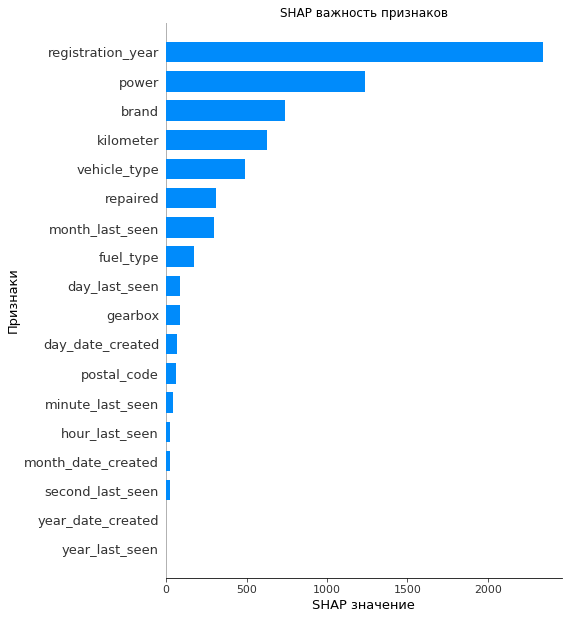

In [119]:
shap.summary_plot(shap_values, X_test_lgbm, color_bar_label='Признаки', show=False, plot_type='bar', show_values_in_legend=True, max_display=100)
plt.title('SHAP важность признаков')
plt.xlabel('SHAP значение')
plt.ylabel('Признаки', fontsize=13)

plt.tight_layout()
plt.show()

Больше всего влияют на цену год регистрации, мощность двигателя, марка автомобиля. Как и следовало ожидать, год последнего просмотра и год создания записи в БД не влияют на модель, поэтому их можно было бы удалить, если бы потребовалось еще сэкономить время обучения, например.

## <a id='toc6_'></a> Общий вывод [&#8593;](#toc0_)

*Предоработка и исследовательский анализ*

В рамках первичной обработки были удалены полные дубликаты. Также в 5 столбцах были обнаружены пропуски, которые были заполнены.

В исследовательском анализе данных были обнаружены аномалии, которые мы удалили для того, чтобы модели были не смещенными в сторону аномалий, а именно: 

- невозможный или неактуальный для нашей модели год регистрации
- нехарактерные для автомобилей значения мощности

*Корреляционный анализ*
В ходе исследования таблицы корреляции были обнаружены не влияющие на целевой признак характеристики, которые удалены: registraion_month, date_crawled и model, имеющий высокую корреляцию с признаком brand.

*Пайплайны и модели*
Было рассмотрено 3 модели с различными параметрами, лучшей из которой оказалась LGBMRegressor со значением метрики RMSE = 1688 на тренировочных и 1693 на тестовых данных соответственно.

После анализа важности признаков так же удалось найти не влияющие на модель, а именно: год создания записи и год последнего просмотра записи в БД. Наиболее важными, как и следовало ожидать, являются признаки: марка авто, мощность двигателя и год регистрации.
